<a href="https://colab.research.google.com/github/akshatsingh22/FAKE-NEWS-DETECTION-USING-MACHINE-LEARNING/blob/master/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***UPLOAD DATASET***

In [1]:
# load the dataset from local disk to google colab
from google.colab import files
uploaded = files.upload()

Saving fake_news.json to fake_news.json


***IMPORT ALL THE NECESSARY PACKAGES***

In [1]:
import io
import json
import itertools
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import make_classification
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

!pip install --upgrade scikit-learn
from sklearn.metrics import plot_confusion_matrix


from collections import Counter
import nltk
from nltk.corpus import stopwords



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.1)


***PLOT TOTAL TRUE AND FAKE HEADLINES***

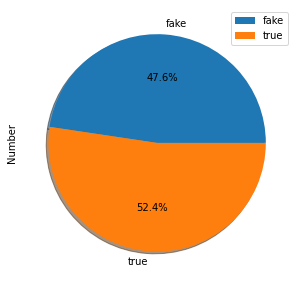

In [2]:
# df holds the entire fake news file
df=pd.read_json('/content/fake_news.json', lines=True);


# fake_headlines holds onlt the headlines that are fake
fake_headlines=df[df.is_sarcastic==1];
no_of_fake=(len(fake_headlines.index));

# true_headlines holds only the headlines that are true 
true_headlines=df[df.is_sarcastic==0];
no_of_true=(len(true_headlines.index));

df3= pd.DataFrame({'Number': [no_of_fake, no_of_true]},
                    index= ['fake', 'true'],);                     
plot = df3.plot.pie(y='Number',figsize=(5, 5),shadow=True,autopct='%1.1f%%');              



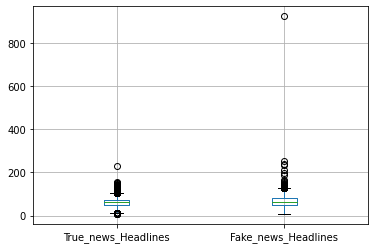

In [3]:
# calculate length of headline when headline is true news and save in variable True_news
cal_length = pd.Series(df.headline[df.is_sarcastic==0])
True_news = cal_length.str.len()
# calculate length of headline when headline is true news and save in variable True_news
cal_length1 = pd.Series(df.headline[df.is_sarcastic==1])
Fake_news = cal_length1.str.len()
# making a DataFrame of the lengths obtained above and plotting in boxplot
graph = pd.DataFrame({'True_news_Headlines': True_news, 'Fake_news_Headlines': Fake_news})
plt = graph.boxplot()

***SPLIT THE DATASET IN TRAIN VALIDATION AND TEST SETS***

In [0]:
# is_sarcastic is dependent of headline so assign X as headline and y as is_sarcastic
X =df.headline
y =df.is_sarcastic

# SPLIT THE DATA INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

***PRINT TO CHECK IF THE SPLIT IS DONE PROPERLY***

In [5]:
print('Total number of training data:',len(X_train))
print('Total number of Real news in training data:',len(X_train[y_train==0]))
print('Total number of Fake news in training data:',len(X_train[y_train==1]))

print('Total number of Test data:',len(X_test))
print('Total number of Real news in Test data:',len(X_test[y_test==0]))
print('Total number of Fake news in Test data:',len(X_test[y_test==1]))

Total number of training data: 17171
Total number of Real news in training data: 8979
Total number of Fake news in training data: 8192
Total number of Test data: 5724
Total number of Real news in Test data: 2991
Total number of Fake news in Test data: 2733


***PLOT COMMON WORDS IN TRUE AND FAKE HEADLINES***

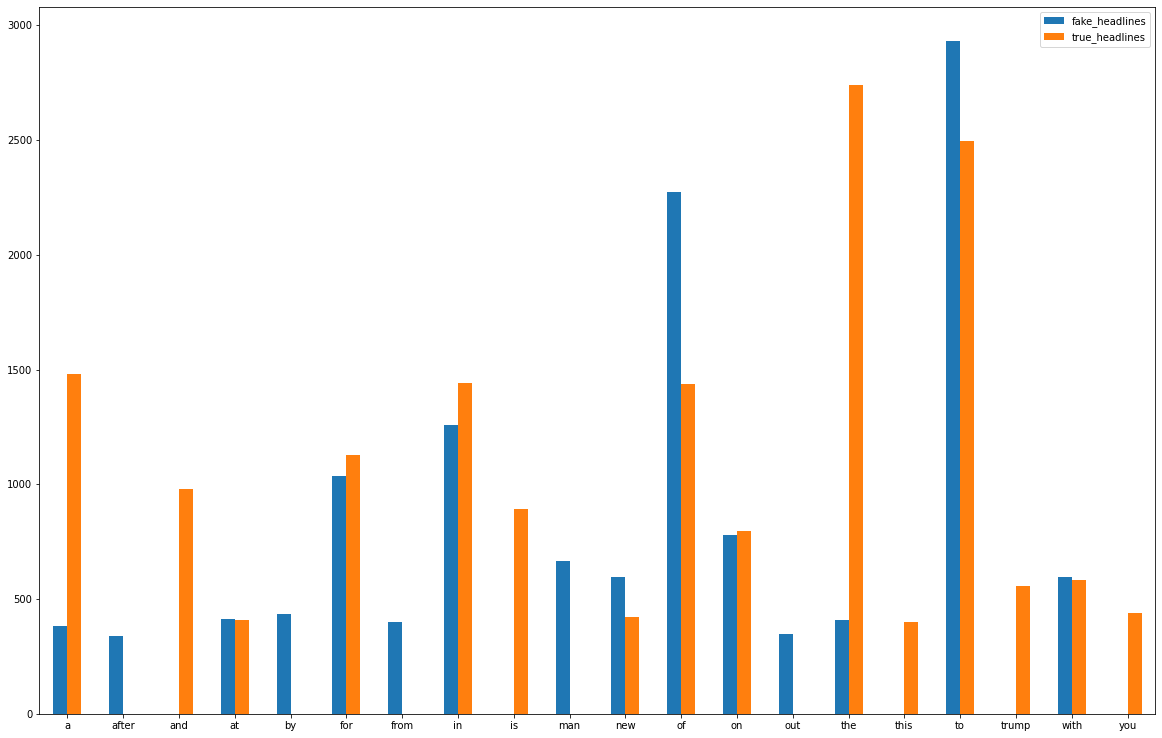

In [6]:
common_words_fake_headlines=pd.Series(' '.join(X_train[y_train==1]).lower().split()).value_counts()[:15];
common_words_true_headlines=pd.Series(' '.join(X_train[y_train==0]).lower().split()).value_counts()[:15];
df1 = pd.DataFrame({'fake_headlines': common_words_fake_headlines,
                   'true_headlines': common_words_true_headlines
                    });
plt=df1.plot.bar(rot=0,figsize=(20,13));
plt.figure.savefig('comparison.png',dpi=400)

***IMPORT NLTK TO STOP THE COMMON ENGLISH WORDS***

In [7]:
# import nltk to stop the common english words e.g is,the,to
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# saving the wordlist in stop
from nltk.corpus import stopwords
stop = stopwords.words('english')

***APPLY LIST COMPREHENSION TO REMOVE THE STOPWORDS***

In [9]:
# Taking the headline and splitting it with str.split() applying list comprehension to remove the stopwords
X_train=X_train.str.split().apply(lambda x: [item for item in x if item not in stop])
# print the first five rows of the dataset
print(X_train.head())

8303     [environmentalists, speak, excessive, cheese, ...
3114     [pope, cleans, dead, angel, flew, sistine, cha...
4512     [writer's, guide, writer, 6:, influencer, -, l...
22886        [nuclear-bomb, instructions, found, pentagon]
3712     [trump, supporters, organize, rallies, across,...
Name: headline, dtype: object


In [10]:
# The output is splitted so join it with str.join and with a space will give the normal string back
X_train=X_train.str.join(' ');
# print the first five rows of the dataset
print(X_train.head())

8303      environmentalists speak excessive cheese logging
3114     pope cleans dead angel flew sistine chapel window
4512     writer's guide writer 6: influencer - loudest ...
22886             nuclear-bomb instructions found pentagon
3712      trump supporters organize rallies across country
Name: headline, dtype: object


***PLOT MOST COMMON WORDS IN TRUE AND FAKE HEADLINES AFTER REMOVING STOPWORDS***

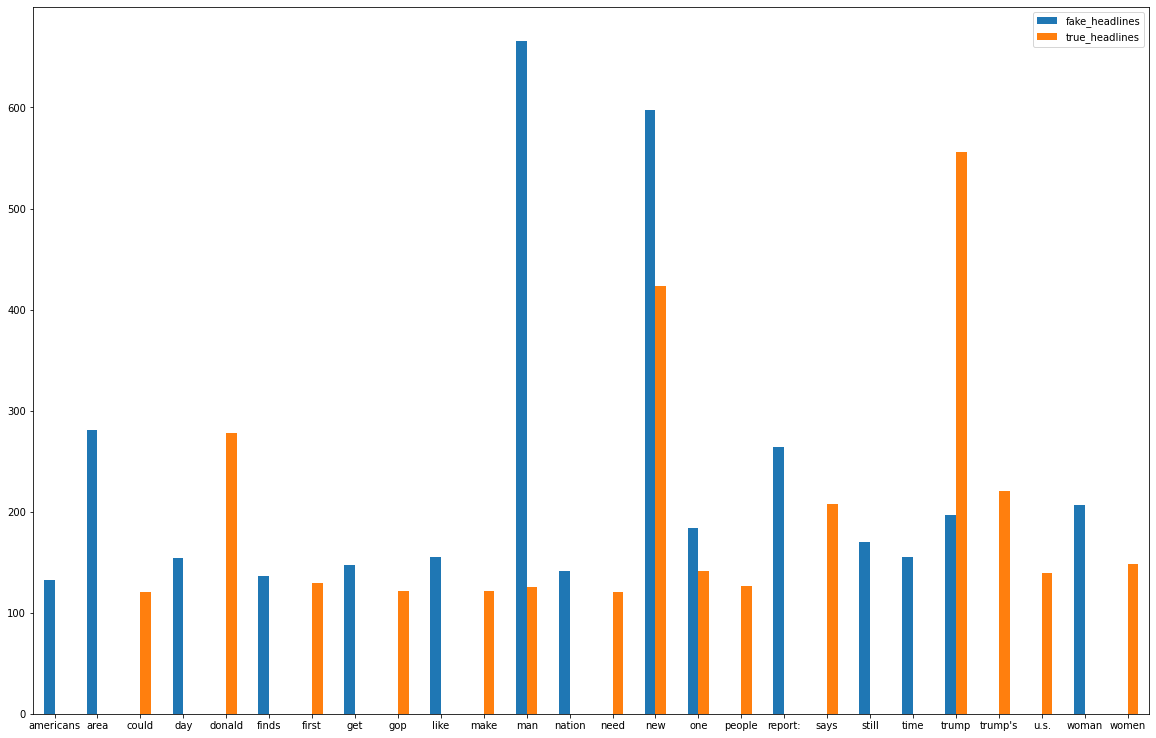

In [11]:
common_words_cleaned_fake_headlines=pd.Series(' '.join(X_train[y_train==1]).lower().split()).value_counts()[:15];
common_words_cleaned_true_headlines=pd.Series(' '.join(X_train[y_train==0]).lower().split()).value_counts()[:15];
df2 = pd.DataFrame({'fake_headlines': common_words_cleaned_fake_headlines,
                   'true_headlines': common_words_cleaned_true_headlines
                    });
plt=df2.plot.bar(rot=0,figsize=(20,13));
plt.figure.savefig('comparison.png',dpi=400)

***REMOVING UNWANTED VALUES IN FROM THE DATASET***

In [12]:
#Still there are values which has no meaning in the training dataset so replacing it
X_train = X_train.str.replace(':', '')
X_train = X_train.str.replace('$', '')
X_train = X_train.str.replace('%', '')
X_train = X_train.str.replace('0', '')
X_train = X_train.str.replace('1', '')
X_train = X_train.str.replace('2', '')
X_train = X_train.str.replace('3', '')
X_train = X_train.str.replace('4', '')
X_train = X_train.str.replace('5', '')
X_train = X_train.str.replace('6', '')
X_train = X_train.str.replace('7', '')
X_train = X_train.str.replace('8', '')
X_train = X_train.str.replace('9', '')
# print the first five rows of the training dataset
X_train.head()

8303      environmentalists speak excessive cheese logging
3114     pope cleans dead angel flew sistine chapel window
4512     writer's guide writer  influencer - loudest vo...
22886             nuclear-bomb instructions found pentagon
3712      trump supporters organize rallies across country
Name: headline, dtype: object

**FEATURE EXTRACTION USING TFIDF**

In [0]:
# Create `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer() 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)
tfidf_val = tfidf_vectorizer.transform(X_val)

In [14]:
# Get the last 20 feature names
print(tfidf_vectorizer.get_feature_names()[:20])

['aaa', 'aaron', 'aatish', 'ab', 'abandon', 'abandoned', 'abandoning', 'abandons', 'abbas', 'abbey', 'abbi', 'abby', 'abc', 'abcs', 'abdomen', 'abdominable', 'abduction', 'abductions', 'abdul', 'abe']


***FITTING AND PREDICTION***

In [15]:
clf=MultinomialNB();
clf.fit(tfidf_train, y_train,sample_weight=1);
pred= clf.predict(tfidf_val);
score=accuracy_score(y_val, pred);
print("Validation Accuracy:   %0.3f" % score);

cm=confusion_matrix(y_val, pred);
print(cm);

Validation Accuracy:   0.796
[[2638  377]
 [ 792 1917]]


In [16]:
clf1=LogisticRegression(max_iter=2000);
clf1.fit(tfidf_train, y_train);
pred1= clf1.predict(tfidf_val);
score1=accuracy_score(y_val, pred1);
print("Validation Accuracy:   %0.3f" % score1);

cm=confusion_matrix(y_val, pred1);
print(cm);

Validation Accuracy:   0.806
[[2617  398]
 [ 711 1998]]


In [17]:
clf2=svm.SVC(gamma='scale', probability=True);
# clf=LogisticRegression(max_iter=2000);
clf2.fit(tfidf_train, y_train);
pred2= clf2.predict(tfidf_val);
score2=accuracy_score(y_val, pred2);
print("Validation Accuracy:   %0.3f" % score2);

cm=confusion_matrix(y_val, pred2);
print(cm);

Validation Accuracy:   0.813
[[2641  374]
 [ 696 2013]]


In [18]:
clf3=RandomForestClassifier(n_estimators=50, max_depth=None, random_state=0);
clf3.fit(tfidf_train, y_train);
pred3= clf3.predict(tfidf_val);
score3=accuracy_score(y_val, pred3);
print("Validation Accuracy:   %0.3f" % score3);

cm=confusion_matrix(y_val, pred3);
print(cm);

Validation Accuracy:   0.768
[[2467  548]
 [ 782 1927]]


***SAVING THE BEST MODEL***

In [0]:
# save the final model to disk using pickle
fake_news_detector= 'fake_news_detector'
pickle.dump(clf2, open(fake_news_detector, 'wb'))

In [20]:
pred= clf2.predict(tfidf_test);
score=accuracy_score(y_test, pred);
cm=confusion_matrix(y_test, pred);
print(cm);
print("Out of Sample accuracy:   %0.3f" % score);

[[2588  403]
 [ 674 2059]]
Out of Sample accuracy:   0.812
